In [ ]:
%matplotlib inline

import cv2
import pandas as pd
import numpy as np
import tensorflow as tf

from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.utils import get_file

## SSD Anchors

![Imgur](https://i.imgur.com/ztgXQQO.png)

우리는 각 Feature Map 마다 가상의 box인 Anchor을 둡니다. 이 Anchor는 Multi-Head Network가 물체를 잡을 때 기준이 되는 Box로, Anchor에 물체가 Threhold 이상 겹쳤을 때에만 동작하도록 구성됩니다. SSD 모델은 각 Layer 별로 Anchor를 두어, Multi Scale의 이미지에 동작할 수 있도록 구현되어 있습니다.

*SSD에서는 Anchor 대신 Prior Box라는 표현을 썼습니다. 용어의 통일을 위해 Prior Box를 Anchor라 하겠습니다*

### DetectionDataset 가져오기


#### - Dataset 불러오기

In [2]:
fpath = get_file("mnist_detection.npz",
                 "https://craftsangjae.s3.ap-northeast-2.amazonaws.com/data/mnist_detection.npz")
data = np.load(fpath)

train_images = data['train_images']
train_labels = data['train_labels']
test_images = data['test_images']
test_labels = data['test_labels']

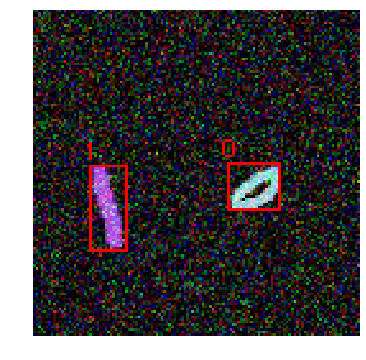

In [3]:
target_index = 0
target_image = train_images[target_index].copy()
target_labels = train_labels[train_labels[:,0]==target_index]

for label in target_labels:
    cx, cy, w, h = label[1:5]
    cls = label[-1]
    
    cv2.rectangle(target_image, 
                  (cx-w//2,cy-h//2), 
                  (cx-w//2+w,cy-h//2+h),
                  (255,0,0),1)
    
    cv2.putText(target_image, str(cls), 
                (cx-w//2-3,cy-h//2-3),
                cv2.FONT_HERSHEY_SIMPLEX, 
                0.3, (255,0,0), 1)

plt.figure(figsize=(6,6))
plt.imshow(target_image)
plt.axis('off')
plt.show()

#### - 글자 폭과 높이의 분포 확인하기

In [4]:
widths = train_labels[:,3]
heights = train_labels[:,4]

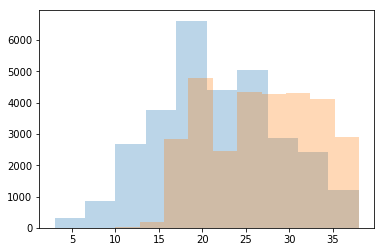

In [5]:
plt.hist(widths, alpha=0.3, label="widths")
plt.hist(heights, alpha=0.3, label="heights")
plt.show()

대부분의 박스가 10~35 사이에 위치하게 됩니다. Default Box의 크기(Scale)를 15, 25, 35으로 두도록 하겠습니다.

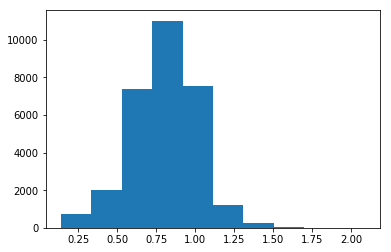

In [6]:
plt.hist(widths/heights,)
plt.show()

글자의 가로/세로 비율($\frac{width}{height}$)은 0.2~1.6까지 분포합니다.

### Anchor 구성하기

![Imgur](https://i.imgur.com/ztgXQQO.png)

#### - Anchor의 크기 산정하기


우리는 위에서 Anchor의 Scale은 $[10,25,40]$로 두고, Anchor의 Ratio은 $ [(1,1),(1.5,0.5),(1.2,0.8),(0.8,1.2),(1.4,1.4)]$로 두었습니다. Scale은 각 Source Layer에 매칭됩니다. 얕은 층의 Source Layer는 영상에서 세밀한 정보를 가지고 있고, 깊은 층의 Source Layer은 영상에서 전체적인 정보를 가지고 있습니다. 그렇기 때문에 작은 사물을 잡을 때에는 얕은 층의 Layer가 유리하고, 큰 사물을 잡을 때에는 깊은 층의 Layer가 유리합니다.

In [7]:
strides = [4, 8, 16]
scales = [10, 20, 30]
ratios = [(1,1),     # ratio : 1.
          (0.5,1.5), # ratio : 0.33
          (0.8,1.2), # ratio : 0.67
          (1.2,0.8), # ratio : 1.5
          (1.4,1.4)] 

bbox_df = pd.DataFrame(columns=['stride', 'w', 'h'])
for scale, stride in zip(scales, strides):
    for ratio in ratios:
        w = np.round(scale * ratio[0]).astype(np.int)
        h = np.round(scale * ratio[1]).astype(np.int)
        bbox_df.loc[len(bbox_df) + 1] = [stride, w, h]

bbox_df.stride = bbox_df.stride.astype(np.int)
bbox_df.w = bbox_df.w.astype(np.int)
bbox_df.h = bbox_df.h.astype(np.int)

In [8]:
bbox_df

,stride,w,h
1,4,10,10
2,4,5,15
3,4,8,12
4,4,12,8
5,4,14,14
6,8,20,20
7,8,10,30
8,8,16,24
9,8,24,16
10,8,28,28


#### - Feature Map의 각 점에 Anchor 배치하기

위에서 주어진 Default box의 Feature Map이 아래와 같이 주어지게 됩니다.

In [9]:
target_index = 0
image = train_images[target_index].copy()
labels = train_labels[train_labels[:,0]==target_index]

In [10]:
height, width = image.shape[:2]
multi_boxes = []
for stride, df in bbox_df.groupby('stride'):
    boxes = []
    for idx, row in df.iterrows():
        stride, box_width, box_height = row.stride, row.w, row.h
        ys, xs = np.mgrid[0:height:stride, 0:width:stride]
        box_width = np.ones_like(xs) * box_width
        box_height = np.ones_like(ys) * box_height
        center_xs = stride//2 + xs
        center_ys = stride//2 + ys

        block_centers = np.stack((center_xs, center_ys, 
                                  box_width, box_height),
                                 axis=-1)
        # Block Centers : {H_f,W_f,4}
        boxes.append(block_centers)
    boxes = np.stack(boxes, axis=2)
    # Boxes : {H_f,W_f,N_prior,4}    
    boxes = np.reshape(boxes, (-1, 4))
    # Boxes : {H_f*W_f*N_prior,4}
    multi_boxes.append(boxes)

위의 정보를 시각화하면 아래와 같습니다. 행 방향으로는 Head Network의 순서대로, 열 방향으로는 Prior Ratio의 순서대로 구성하였습니다.

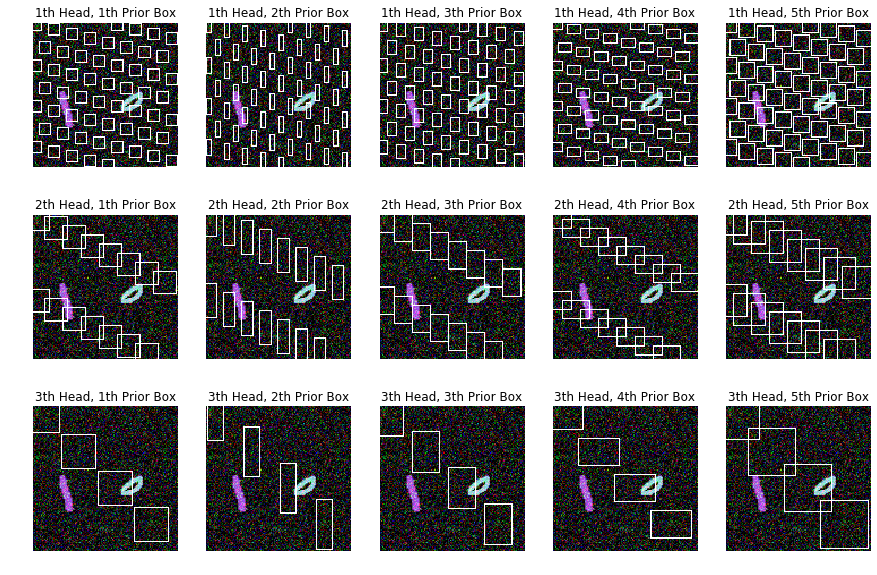

In [11]:
fig = plt.figure(figsize=(15,10))

for i in range(3):
    for j in range(5):
        target_image = image.copy()
        boxes = multi_boxes[i][j::5*18].reshape(-1,4)
        for box in boxes:
            cx, cy, w, h = box
            cv2.rectangle(target_image, 
                          (cx-w//2, cy-h//2), (cx+w//2,cy+h//2),
                          (255,255,255), 1)
        
        ax = fig.add_subplot(3,5,i*5+j+1)
        ax.set_title(f"{i+1}th Head, {j+1}th Prior Box")
        ax.axis('off')
        ax.imshow(target_image)
plt.show()

위의 작업을 클래스로 구현하면 아래와 같이 됩니다.

In [12]:
class Anchors:
    """
    Anchor Configuration Class
    """
    bbox_df = pd.DataFrame()

    def __init__(self, strides, scales, ratios):
        self.strides = strides
        self.scales = scales
        self.ratios = ratios
        self.setup()

    def generate(self, image_shape):
        """
        image_shape에 맞춰서, Anchor(==Default Boxes)를 구성

        return :
        (# Anchors, 4)로 이루어진 출력값 생성
        """
        height, width = image_shape[:2]
        multi_boxes = []
        for stride, df in self.bbox_df.groupby('stride'):
            boxes = []
            for idx, row in df.iterrows():
                stride, box_width, box_height = row.stride, row.w, row.h
                ys, xs = np.mgrid[0:height:stride, 0:width:stride]
                box_width = np.ones_like(xs) * box_width
                box_height = np.ones_like(ys) * box_height
                center_xs = stride // 2 + xs
                center_ys = stride // 2 + ys

                block_centers = np.stack((center_xs, center_ys,
                                          box_width, box_height),
                                         axis=-1)
                boxes.append(block_centers)
            boxes = np.stack(boxes, axis=2)
            boxes = np.reshape(boxes, (-1, 4))
            multi_boxes.append(boxes)
        multi_boxes = np.concatenate(multi_boxes, axis=0)
        return multi_boxes

    def setup(self):
        bbox_df = pd.DataFrame(columns=['stride', 'w', 'h'])
        for scale, stride in zip(self.scales, self.strides):
            for ratio in self.ratios:
                w = np.round(scale * ratio[0]).astype(np.int)
                h = np.round(scale * ratio[1]).astype(np.int)
                bbox_df.loc[len(bbox_df) + 1] = [stride, w, h]

        bbox_df.stride = bbox_df.stride.astype(np.int)
        bbox_df.w = bbox_df.w.astype(np.int)
        bbox_df.h = bbox_df.h.astype(np.int)
        self.bbox_df = bbox_df

### Matching Strategy 구현하기

우리는 학습을 시킬 때, Prior Box가 최소 50%이상 겹친 박스에 대해서만, 사물이 있다고 판정하고 학습을 시킵니다. 50% 미만으로 겹친 박스들은 전부 Background라고 판정합니다. 우리는 Prior Box와 사물이 있는 박스를 위미하는 Ground Truth Box를 각각 서로 얼마나 겹치는지를 계산해야 합니다. 

![Imgur](https://i.imgur.com/mnlYIBL.png)

우리는 위와 같이 $(x_{min},y_{min},x_{max},y_{max})$을 가지고 겹친 넓이를 구할 수 있습니다.

In [13]:
target_index = 0
image = train_images[target_index].copy()
ground_truths = train_labels[train_labels[:,0]==target_index]


gt_boxes = ground_truths[:,1:5]
gt_labels = ground_truths[:,-1]

anchor = Anchors(strides, scales, ratios)

pr_boxes = anchor.generate(image.shape)
print("gt boxes의 shape : ", gt_boxes.shape)
print("prior boxes의 shape :", pr_boxes.shape)

gt boxes의 shape :  (2, 4)
prior boxes의 shape : (6720, 4)


In [14]:
gt_boxes

array([[86, 69, 20, 18],
       [29, 77, 14, 33]])

In [15]:
pr_boxes

array([[  2,   2,  10,  10],
       [  2,   2,   5,  15],
       [  2,   2,   8,  12],
       ...,
       [120, 120,  24,  36],
       [120, 120,  36,  24],
       [120, 120,  42,  42]])

![Imgur](https://i.imgur.com/lXNlMmc.png)

#### - Pivot Bounding Boxes

우리는 동시에 GT Boxes와 Prior Boxes의 IOU를 계산하기 위해서는 우선 두 벡터(`gt_boxes`,`pr_boxes`)를 Pivot해주어야 합니다.

![Imgur](https://i.imgur.com/xBFzmhW.png)

In [16]:
exp_gt_boxes = gt_boxes[:,None] # Ground truth box가 행 기준으로 정렬되도록
exp_pr_boxes = pr_boxes[None,:] # prior box가 열 기준으로 정렬되도록

#### - Calculate Intersection Over Union

그리고 우리는 이제 전체 면적 중 얼마나 겹쳤는지를 의미하는 IoU(Intersection Over Union)을 계산해야 합니다.<br>
수식은 아래와 같습니다.

![Imgur](https://i.imgur.com/B5Y0Erv.png)

![Imgur](https://i.imgur.com/w01apzz.png)

In [17]:
# 2.1. Calculate Overlap
gt_cx, gt_cy, gt_w, gt_h = exp_gt_boxes.transpose(2,0,1)
pr_cx, pr_cy, pr_w, pr_h = exp_pr_boxes.transpose(2,0,1)

# (cx,cy,w,h) -> (xmin,ymin,xmax,ymax)
gt_xmin, gt_xmax = gt_cx-gt_w/2, gt_cx+gt_w/2
gt_ymin, gt_ymax = gt_cy-gt_h/2, gt_cy+gt_h/2
pr_xmin, pr_xmax = pr_cx-pr_w/2, pr_cx+pr_w/2
pr_ymin, pr_ymax = pr_cy-pr_h/2, pr_cy+pr_h/2

# 겹친 사각형의 너비와 높이 구하기
in_xmin = np.maximum(gt_xmin, pr_xmin)
in_xmax = np.minimum(gt_xmax, pr_xmax)
in_width = np.maximum(0,in_xmax - in_xmin) # 음수인 경우 0으로 바뀜

in_ymin = np.maximum(gt_ymin, pr_ymin)
in_ymax = np.minimum(gt_ymax, pr_ymax)
in_height = np.maximum(0,in_ymax - in_ymin) # 음수인 경우 0으로 바뀜

# 겹친 사각형의 넓이 구하기
intersection = in_width*in_height

gt_sizes = exp_gt_boxes[...,2] * exp_gt_boxes[...,3]
pr_sizes = exp_pr_boxes[...,2] * exp_pr_boxes[...,3]

# 2.2. Calculate Combined region
union = (gt_sizes + pr_sizes) - intersection

# Result
iou = (intersection / (union+1e-5)) # 0 나누기 방지를 위함

위의 알고리즘을 메소드로 구현하면 아래와 같습니다.

In [18]:
def calculate_iou(gt_boxes, pr_boxes):
    # 1. pivot bounding boxes 
    exp_gt_boxes = gt_boxes[:,None] # Ground truth box가 행 기준으로 정렬되도록
    exp_pr_boxes = pr_boxes[None,:] # prior box가 열 기준으로 정렬되도록

    # 2. calculate intersection over union
    # 2.1. Calculate Intersection
    gt_cx, gt_cy, gt_w, gt_h = exp_gt_boxes.transpose(2,0,1)
    pr_cx, pr_cy, pr_w, pr_h = exp_pr_boxes.transpose(2,0,1)

    # (cx,cy,w,h) -> (xmin,ymin,xmax,ymax)
    gt_xmin, gt_xmax = gt_cx-gt_w/2, gt_cx+gt_w/2
    gt_ymin, gt_ymax = gt_cy-gt_h/2, gt_cy+gt_h/2
    pr_xmin, pr_xmax = pr_cx-pr_w/2, pr_cx+pr_w/2
    pr_ymin, pr_ymax = pr_cy-pr_h/2, pr_cy+pr_h/2

    # 겹친 사각형의 너비와 높이 구하기
    in_xmin = np.maximum(gt_xmin, pr_xmin)
    in_xmax = np.minimum(gt_xmax, pr_xmax)
    in_width = np.maximum(0,in_xmax - in_xmin)

    in_ymin = np.maximum(gt_ymin, pr_ymin)
    in_ymax = np.minimum(gt_ymax, pr_ymax)
    in_height = np.maximum(0,in_ymax - in_ymin)

    # 겹친 사각형의 넓이 구하기
    intersection = in_width*in_height

    gt_sizes = exp_gt_boxes[...,2] * exp_gt_boxes[...,3]
    pr_sizes = exp_pr_boxes[...,2] * exp_pr_boxes[...,3]

    # 2.2. Calculate Union
    union = (gt_sizes + pr_sizes) - intersection

    # 0 나누기 방지를 위함
    return (intersection / (union+1e-5))

위의 로직을 통해, prior boxes와 ground truth boxes가 겹치는 갯수는 아래와 같습니다.

In [19]:
iou = calculate_iou(gt_boxes, pr_boxes)

iou_threshold = 0.5
match_indices = np.argwhere(iou>=iou_threshold)
print(match_indices.shape)

(8, 2)


빨간색은 `gt_boxes`이고, 파란색과 노란색은 `pr_boxes`입니다. 파란 색은 `pr_boxes` 중 matching 되지 못한 것, 노란 색은 `pr_boxes` 중 Matching 된 것입니다.

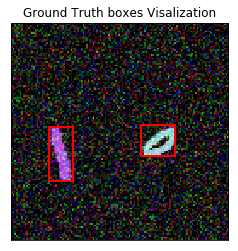

In [20]:
target_indices = match_indices

visualized = image.copy()
for box in gt_boxes[target_indices[:,0]]:
    cx, cy, w, h = box
    cv2.rectangle(visualized, 
                  (cx-w//2,cy-h//2),(cx+w//2,cy+h//2),
                  (255,0,0), 1)
plt.title("Ground Truth boxes Visalization")
plt.xticks([])
plt.yticks([])
plt.imshow(visualized)
plt.show()

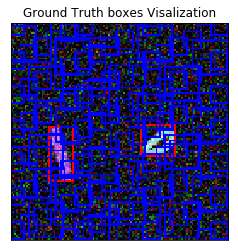

In [21]:
target_indices = match_indices

for box in pr_boxes[::50]:
    cx, cy, w, h = box
    cv2.rectangle(visualized, 
                  (cx-w//2,cy-h//2),(cx+w//2,cy+h//2),
                  (0,0,255), 1)
plt.title("Ground Truth boxes Visalization")
plt.xticks([])
plt.yticks([])
plt.imshow(visualized)
plt.show()

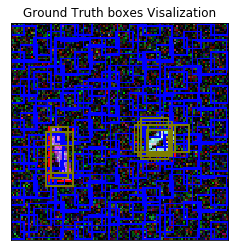

In [22]:
target_indices = match_indices

for box in pr_boxes[target_indices[:,1]]:
    cx, cy, w, h = box
    cv2.rectangle(visualized, 
                  (cx-w//2,cy-h//2),(cx+w//2,cy+h//2),
                  (125,125,0), 1)
plt.title("Ground Truth boxes Visalization")
plt.xticks([])
plt.yticks([])
plt.imshow(visualized)
plt.show()

### Training Objective 구성하기

우리의 목표는 Matching된 Prior Box에 있는 숫자를 `multi-box head Network`로<br>
(1) 어떤 숫자인지 파악하고 (2) 숫자의 위치가 어디에 있는지를 파악하는데에 이용하고자 합니다.

즉 모델에서 예측하고자 하는 출력의 형태로 우리는 바꾸어 주어야 합니다.

#### - Classification Network의 정답 구성하기

우리는 match_indices에 포함된 것들 제외하고는 모두 Background로 라벨링을 해주어야 합니다.

In [23]:
from tensorflow.keras.utils import to_categorical

In [24]:
gt_labels = ground_truths[:,-1]

num_classes = 10

y_true_clf = np.ones((pr_boxes.shape[0])) * num_classes # Background로 일단 채움
y_true_clf[match_indices[:,1]] = gt_labels[match_indices[:,0]]

y_true_clf = to_categorical(y_true_clf, 
                            num_classes=num_classes+1) # One-Hot Encoding
y_true_clf

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

위 과정을 메소드로 구현하면 아래와 같습니다.

In [25]:
def convert_clf_gt_to_model_form(gt_labels, pr_boxes, match_indices,
                                 num_classes=10):
    y_true_clf = np.ones((pr_boxes.shape[0])) * num_classes
    y_true_clf[match_indices[:,1]] = gt_labels[match_indices[:,0]]

    return to_categorical(y_true_clf, num_classes=num_classes+1) 

In [26]:
y_true_clf = convert_clf_gt_to_model_form(gt_labels, pr_boxes, match_indices)
y_true_clf

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [27]:
y_true_clf[match_indices[:,1]]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

#### - Localization Network의 정답 구성하기

Localization Network는 Prior Box내에 있는 사물의 위치를 보정하여 줍니다. 보정 수식은 아래와 같습니다.<br>
$
y_{true}^{loc} = (\hat g^{cx},\hat g^{cy}, \hat g^{w},\hat g^{h}) \\
\hat g^{cx} = \frac{(g^{cx} - p^{cx})}{p^{w}} \\
\hat g^{cy} = \frac{(g^{cy} - p^{cy})}{p^{h}} \\
\hat g^{w} = log(\frac{g^{w}}{p^{w}}) \\
\hat g^{h} = log(\frac{g^{h}}{p^{h}}) \\
$

In [28]:
y_true_loc = np.zeros((pr_boxes.shape[0],4))
g_cx, g_cy, g_w, g_h = gt_boxes[match_indices[:,0]].transpose()
p_cx, p_cy, p_w, p_h = pr_boxes[match_indices[:,1]].transpose()

hat_g_cx = (g_cx - p_cx) / p_w
hat_g_cy = (g_cy - p_cy) / p_h
hat_g_w = np.log(g_w / p_w)
hat_g_h = np.log(g_h / p_h)

hat_g = np.stack([hat_g_cx,hat_g_cy,hat_g_w,hat_g_h],axis=1)
y_true_loc[match_indices[:,1]] = hat_g
y_true_loc

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [29]:
y_true_loc[match_indices[:,1]]

array([[ 0.        , -0.07142857,  0.35667494,  0.25131443],
       [ 0.1       ,  0.05      ,  0.        , -0.10536052],
       [ 0.125     ,  0.04166667,  0.22314355, -0.28768207],
       [ 0.08333333,  0.0625    , -0.18232156,  0.11778304],
       [-0.25      ,  0.0625    , -0.18232156,  0.11778304],
       [ 0.1       ,  0.03333333,  0.33647224,  0.09531018],
       [ 0.0625    ,  0.04166667, -0.13353139,  0.31845373],
       [ 0.0625    , -0.29166667, -0.13353139,  0.31845373]])

In [30]:
def convert_loc_gt_to_model_form(gt_boxes, pr_boxes, match_indices):
    y_true_loc = np.zeros((pr_boxes.shape[0],4))
    g_cx, g_cy, g_w, g_h = gt_boxes[match_indices[:,0]].transpose()
    p_cx, p_cy, p_w, p_h = pr_boxes[match_indices[:,1]].transpose()

    hat_g_cx = (g_cx - p_cx) / p_w
    hat_g_cy = (g_cy - p_cy) / p_h
    hat_g_w = np.log(g_w / p_w)
    hat_g_h = np.log(g_h / p_h)

    hat_g = np.stack([hat_g_cx,hat_g_cy,hat_g_w,hat_g_h],axis=1)
    y_true_loc[match_indices[:,1]] = hat_g
    return y_true_loc

In [31]:
y_true_loc = convert_loc_gt_to_model_form(gt_boxes, pr_boxes, match_indices)
y_true_loc[match_indices[:,1]]

array([[ 0.        , -0.07142857,  0.35667494,  0.25131443],
       [ 0.1       ,  0.05      ,  0.        , -0.10536052],
       [ 0.125     ,  0.04166667,  0.22314355, -0.28768207],
       [ 0.08333333,  0.0625    , -0.18232156,  0.11778304],
       [-0.25      ,  0.0625    , -0.18232156,  0.11778304],
       [ 0.1       ,  0.03333333,  0.33647224,  0.09531018],
       [ 0.0625    ,  0.04166667, -0.13353139,  0.31845373],
       [ 0.0625    , -0.29166667, -0.13353139,  0.31845373]])

이후에 이 값을 복원하기 위해서는 아래 수식을 이용하면 됩니다.<br>

$
cx_{restore} = \hat g^{cx} * d^w +d^{cx} \\
cy_{restore} = \hat g^{cy} * d^h +d^{cy} \\
w_{restore} = exp^{\hat g^{w}} * d^w \\
h_{restore} = exp^{\hat g^{h}} * d^h \\
$

In [32]:
# 복원 후 동일한지 확인하기
res_cx = (y_true_loc[:,0] 
          * pr_boxes[:,2] 
          + pr_boxes[:,0])
res_cy = (y_true_loc[:,1] 
          * pr_boxes[:,3] 
          + pr_boxes[:,1])
res_w = (np.exp(y_true_loc[:,2])
         *pr_boxes[:,2])
res_h = (np.exp(y_true_loc[:,3])
         *pr_boxes[:,3])

restore_boxes = np.stack([res_cx,res_cy,res_w,res_h], axis=-1)

np.testing.assert_array_almost_equal(gt_boxes[match_indices[:,0]],
                                     restore_boxes[match_indices[:,1]])

#### - SSD Network의 정답값 구성하기

In [33]:
y_true = np.concatenate([y_true_clf, y_true_loc],axis=1)
y_true.shape

(6720, 15)